In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [2]:
data= pd.read_csv('stroke-data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
data.dropna(inplace=True)

Removed the rows with null values present in bmi columns

In [8]:
col=['gender','age','hypertension','heart_disease','avg_glucose_level','bmi','smoking_status','stroke']
new_data=data[col].copy()


,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,105.92,32.5,never smoked,1
3,Female,49.0,0,0,171.23,34.4,smokes,1
4,Female,79.0,1,0,174.12,24.0,never smoked,1
5,Male,81.0,0,0,186.21,29.0,formerly smoked,1


Based on my learnings from article 1 these are the features I selected. 
Males were more prone to strokes when compared to females.
People with hypertension were more to stroke.
People who smoked were at a high risk of strokes.

In [43]:
b=[0,25.1,50.1,80,102.5,np.inf]
l=['very young','young adult','middle adult','very old','out of range']
new_data['age_cat']=pd.cut(new_data['age'],bins=b,labels=l,right=False)

gb=[0,70,85,100,126,np.inf]
gl=['low risk','mid risk','optimal','prediabetic','diabetic']
new_data['glucose_cat']=pd.cut(new_data['avg_glucose_level'],bins=gb,labels=gl,right=False)

bb=[0,18.5,25,30,float('inf')]
bl=['underweight','healthy weight','overweight','obesity']
new_data['bmi_cat']=pd.cut(new_data['bmi'],bins=bb,labels=bl,right=False)
new_data.head(10)

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,glucose_category,bmi_category,age_category,age_cat,glucose_cat,bmi_cat
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1,diabetic,obesity,middle adult,middle adult,diabetic,obesity
2,Male,80.0,0,1,105.92,32.5,never smoked,1,prediabetic,obesity,very old,very old,prediabetic,obesity
3,Female,49.0,0,0,171.23,34.4,smokes,1,diabetic,obesity,young adult,young adult,diabetic,obesity
4,Female,79.0,1,0,174.12,24.0,never smoked,1,diabetic,healthy weight,middle adult,middle adult,diabetic,healthy weight
5,Male,81.0,0,0,186.21,29.0,formerly smoked,1,diabetic,overweight,very old,very old,diabetic,overweight
6,Male,74.0,1,1,70.09,27.4,never smoked,1,mid risk,overweight,middle adult,middle adult,mid risk,overweight
7,Female,69.0,0,0,94.39,22.8,never smoked,1,optimal,healthy weight,middle adult,middle adult,optimal,healthy weight
9,Female,78.0,0,0,58.57,24.2,Unknown,1,low risk,healthy weight,middle adult,middle adult,low risk,healthy weight
10,Female,81.0,1,0,80.43,29.7,never smoked,1,mid risk,overweight,very old,very old,mid risk,overweight
11,Female,61.0,0,1,120.46,36.8,smokes,1,prediabetic,obesity,middle adult,middle adult,prediabetic,obesity


def age_category(age):
    if age >= 25.1 and age <=49.9:
        return  'young adult'
    elif age >= 50.1 and age <=79.9:
        return  'middle adult'
    elif age >= 80.0 and age <=102.5:
        return  'very old'
    elif age<=25:
        return 'very young'
    else:
        return 'out of range'
    

new_df['age_category']=new_df['age'].apply(age_category)
new_df.head(5)

Based on the articles provided by the medical team, I converted age, bmi and avg_glucose_level into categorical variables.

Text(0.5, 1.0, 'stroke distribution by gender')

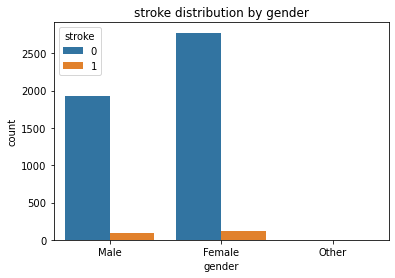

In [44]:
sns.countplot(data=new_data,x='gender',hue='stroke')
plt.title("stroke distribution by gender")

(array([0, 1, 2, 3]),
 [Text(0, 0, 'formerly smoked'),
  Text(1, 0, 'never smoked'),
  Text(2, 0, 'smokes'),
  Text(3, 0, 'Unknown')])

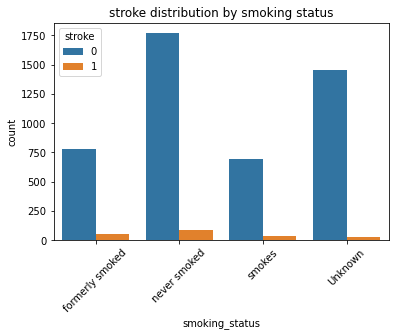

In [45]:
sns.countplot(data=new_data,x='smoking_status',hue='stroke')
plt.title("stroke distribution by smoking status")
plt.xticks(rotation=45)

Text(0.5, 1.0, 'correlation matrix')

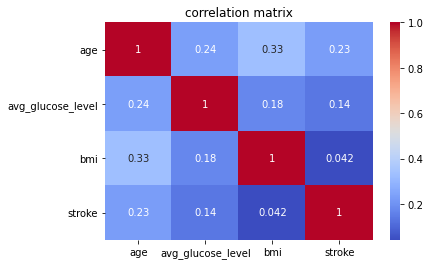

In [28]:
correlation=new_data[['age','avg_glucose_level','bmi','stroke']].corr()
sns.heatmap(correlation,annot=True,cmap='coolwarm')
plt.title('correlation matrix')

Text(0.5, 1.0, 'stroke v/s glucose level ')

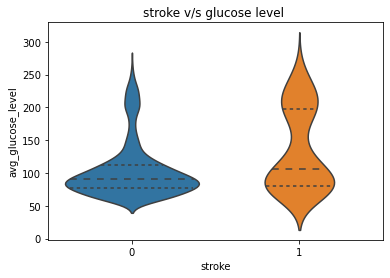

In [46]:
sns.violinplot(data=new_data,x='stroke',y='avg_glucose_level',inner='quartile')
plt.title('stroke v/s glucose level ')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'very young'),
  Text(1, 0, 'young adult'),
  Text(2, 0, 'middle adult'),
  Text(3, 0, 'very old'),
  Text(4, 0, 'out of range')])

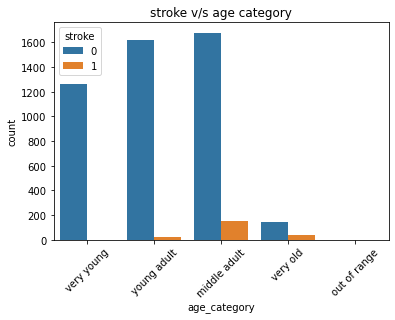

In [47]:
sns.countplot(data=new_data,x='age_category',hue='stroke')
plt.title("stroke v/s age category")
plt.xticks(rotation=45)

In [ ]:
sns.countplot(data=new_data,x='bmi_category',hue='stroke')
plt.title("stroke v/s bmi category")
plt.xticks(rotation=45)

I visualized the effects of various features against stroke to better understand the impact of various features.

In [32]:
feat=['gender','hypertension','heart_disease','smoking_status','age_category','bmi_category','glucose_category']
X=new_data[feat]
Y=new_data['stroke']


In [36]:
c_data=['gender','smoking_status','age_category','bmi_category','glucose_category']
n_data=['hypertension','heart_disease']
X_encoding=pd.get_dummies(X,columns=c_data,drop_first=True)
X_train,X_test,Y_train,Y_test=train_test_split(X_encoding,Y,test_size=0.15,random_state=42,stratify=Y)

Performed encoding on the dataframe to convert the categorical data to use it in machine learning model.

from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
X_sm,Y_sm=smote.fit_resample(X_train,Y_train)

!pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

model=XGBClassifier()
scale=Y_train.value_counts()[0]/Y_train.value_counts()[1]
pg={'n_estimators': [100,200],
            'learning_rate':[0.01,0.1],
           'max_depth':[3,5],
           'scale_pos_weight':[scale,scale*1.5],
   }
gs=GridSearchCV(estimator=model,param_grid=pg,cv=3,scoring='f1',verbose=1)
gs.fit(X_sm,Y_sm)
optimal_model=gs.best_estimator_


y_proba=optimal_model.predict_proba(X_val)[:,1]
y_prediction=(y_proba>=0.4).astype(int)
print("Classification report")
print(classification_report(Y_val,y_prediction))

y_prob=optimal_model.predict_proba(X_test)[:,1]

y_test_prediction=(y_prob>=0.4).astype(int)#optimal_model.predict(X_test)
print("classification report")
print(classification_report(Y_test,y_test_prediction))
print("confusion matrix")
print(confusion_matrix(Y_test,y_test_prediction))


In [41]:


lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

gl = GridSearchCV(lr, param_grid, cv=3, scoring='f1', n_jobs=-1)
gl.fit(X_train, Y_train)

best_lr = gl.best_estimator_
print("Best parameter:", grid_lr.best_params_)



Best Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       706
           1       0.09      0.84      0.16        31

    accuracy                           0.62       737
   macro avg       0.54      0.73      0.46       737
weighted avg       0.95      0.62      0.73       737



In [ ]:
y_pred = best_lr.predict(X_test)


In [ ]:
print("classification Report:")
print(classification_report(Y_test, y_pred))


In [ ]:
print("confusion matrix")
print(confusion_matrix(Y_test, y_pred))

After understanding the client's perspective, the goal of my project was to predict whether a patient is at high risk of experiencing a stroke based on the various features provided in the dataset. The client wanted a solution that would perform well for both well and at risk persons.

The dataset provided to us is an imbalanced one with significantly fewer stroke cases compared to non stroke cases. After reading the articles provided to us by the medical team I performed feture selection and then converted some numerical features into categorical ones.

I then performed visualization on various features to understand their effects on stroke and then prepared the dataframe by encoding it so that it could be used in the model. I performed SMOTE(Synthetic Minority Over Sampling technique) to tackle the imbalance in the datset. I split the datset into train(70%), validation(15%) and test(15%).

After researching and performing trial and error I chose XBGClassifier as it has high performance on classification problems involving imbalanced dataset. The other models I considered were SVM, Random Forest and Ensemble  methods. SVM and Random forest yielded lower recall compared to XGBClassifier. Ensemble methods showed improvements but increased the complexity.

I used GridSearchCV to fine tune the hyperparameters of the model. The parameters I fine tuned were n_estimator, learning_rate, max_depth and scale_pos_weight. I chose to fine tume scale_pos_weight as it allows us to provide a weight to positive class. By fine tuning it, XGBoost will penalize the misclassification of the positive class more heavily than negive class. The score we use to evaluate our gridsearchcv is F1 score as it gives better result for imbalanced dataset.

To evaluate our model we will give more importance to precision and recall rather than accuracy as the dataset is imbalanced. The recall of our model for stroke class is 0.84 and precision for stroke class came out to be 0.09. Having a high recall shows that our model identifies most stroke cases, even at the cost of more false positives. This trade-off is clinically justified as missing a stroke is more costlier than a false alarm. 